In [1]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from scipy.stats import boxcox, norm, ks_2samp
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")

In [96]:
from google.colab import files
uploaded = files.upload()
df_orders = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_orders.head()

StopIteration: 

In [20]:
uploaded = files.upload()

df_order_details = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_order_details.head()

Saving clean_order_details.csv to clean_order_details.csv


,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price
0,2,2,955,5,7.5,37.5
1,3,2,958,5,8.5,42.5
2,5,2,959,5,8.5,42.5
3,6,4,72,50,3.0,150.0
4,7,4,9,50,3.2,160.0


In [70]:
uploaded = files.upload()
df_products = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_products.head()

KeyboardInterrupt: 

In [22]:
df = pd.merge(df_order_details, df_orders, on = 'OrderID')
df = pd.merge(df, df_products, on = 'ProductID')
df.head()

,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,...,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,2,2,955,5,7.5,37.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,997,XXL,Dozen,In Production,2003-07-10,7.15,PCL29
1,3,2,958,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1110,XXL,Dozen,In Production,2003-07-10,8.30,PCL31S
2,5,2,959,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1055,XXL,Dozen,In Production,2003-07-10,7.20,PCL31T
3,6,4,72,50,3.0,150.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,233,S,Dozen,In Production,2003-07-10,2.50,ERK61
4,7,4,9,50,3.2,160.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,325,M,Dozen,In Production,2003-07-10,2.70,ERK61


In [23]:
# Convert date to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df.dtypes

,0
OrderDetailID,int64
OrderID,int64
ProductID,int64
QuantitySold,int64
UnitSalesPrice,float64
total_price,float64
CustomerID,int64
EmployeeID,int64
ShippingMethodID,int64
OrderDate,datetime64[ns]


In [24]:
sales = df.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
sales

,OrderDate,QuantitySold
0,2003-07-10,145
1,2003-07-11,330
2,2003-07-14,768
3,2003-07-15,835
4,2003-07-16,540
...,...,...
741,2006-04-13,2044
742,2006-04-14,92
743,2006-04-18,147
744,2006-04-19,4145


In [97]:
sales = sales.set_index('OrderDate')
sales = sales.asfreq('W-MON')

#Interpolacion de los valores faltantes
sales['QuantitySold'] = sales['QuantitySold'].interpolate()
sales

KeyError: "None of ['OrderDate'] are in the columns"

In [26]:
y = sales['QuantitySold']
y

,QuantitySold
OrderDate,
2003-07-14,768.0
2003-07-21,180.0
2003-07-28,614.0
2003-08-04,573.0
2003-08-11,375.0
...,...
2006-03-20,46.0
2006-03-27,25.0
2006-04-03,1080.0


In [27]:
mean_value = sales['QuantitySold'].mean()
mean_value

1004.5068965517241

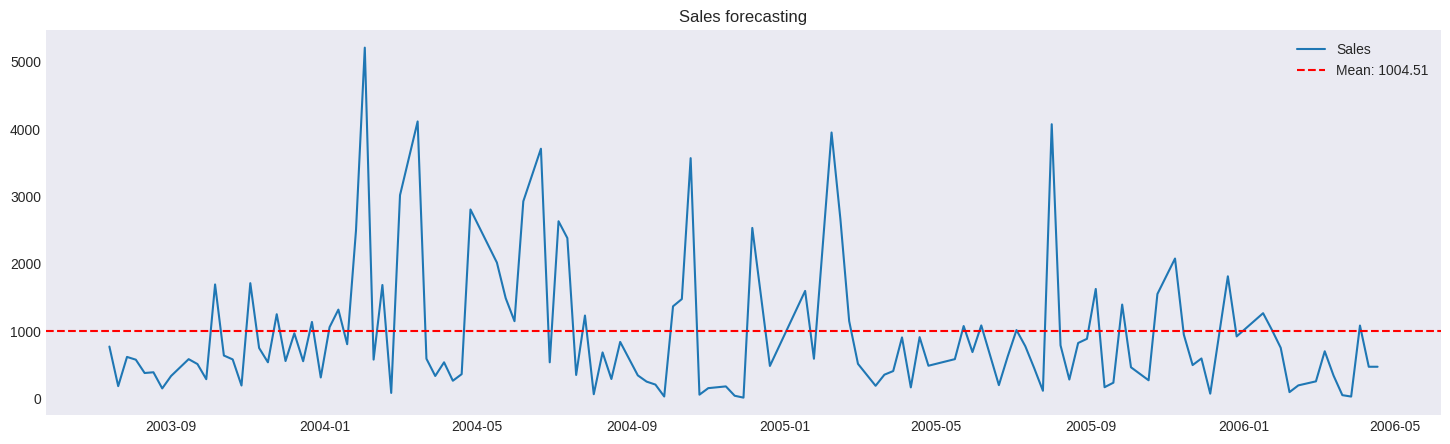

In [28]:
plt.figure(figsize=(18,5))
plt.plot(sales['QuantitySold'], linestyle="-", label = 'Sales')
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()

In [29]:
import seaborn as sns

<Axes: ylabel='QuantitySold'>

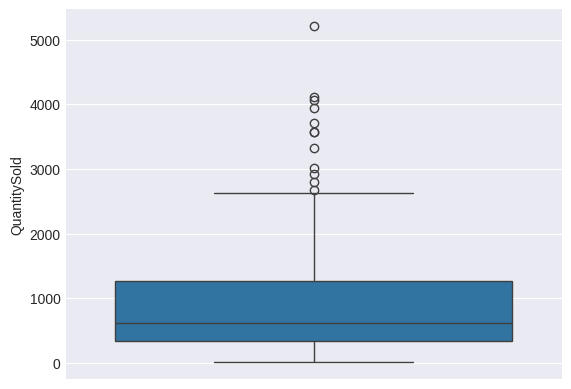

In [30]:
#estudio de valores atipicos
sns.boxplot(sales['QuantitySold'])

In [31]:
q1 = sales['QuantitySold'].quantile(0.25)
q3 = sales['QuantitySold'].quantile(0.75)

iqr = q3-q1

lim_inf = q1 - 1.5*iqr
lim_sup = q3 + 1.5*iqr

outliers = sales[(sales['QuantitySold'] < lim_inf) | (sales['QuantitySold'] > lim_sup)]

perc_out = (len(outliers) / len(sales['QuantitySold'])) * 100

print(f'Percentage outliers:  {perc_out}')

Percentage outliers:  8.275862068965518


In [32]:
sales['QuantitySold'].median(), sales['QuantitySold'].mean()

(620.0, 1004.5068965517241)

In [33]:
# sustituimos los valores atipicos por la mediana

sales['QuantitySold_no_out'] = np.where((sales['QuantitySold'] < lim_inf) | (sales['QuantitySold'] > lim_sup),
                              sales['QuantitySold'].median(), sales['QuantitySold'])

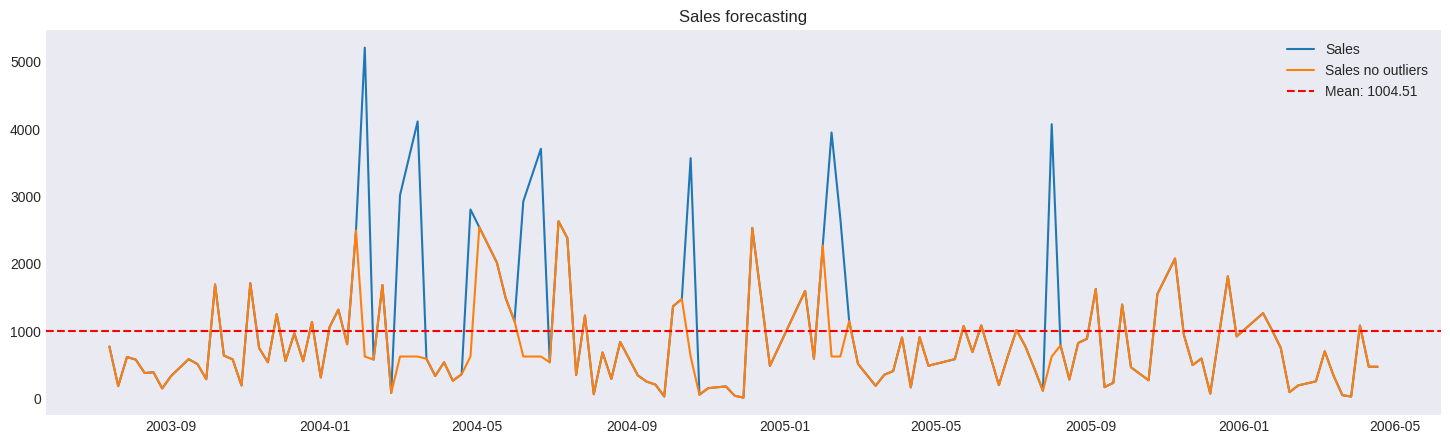

In [34]:
plt.figure(figsize=(18,5))
plt.plot(sales['QuantitySold'], linestyle="-", label = 'Sales')
plt.plot(sales['QuantitySold_no_out'], linestyle="-", label = 'Sales no outliers' )
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()

In [35]:
#sales['QuantitySold'] = sales['QuantitySold_no_out']
#sales.drop(columns=['QuantitySold_no_out'], inplace=True)

p-value Kolmogorov-Smirnov: 2.147655317497006e-86
p-value Shapiro-Wilk: 1.088254714552583e-12


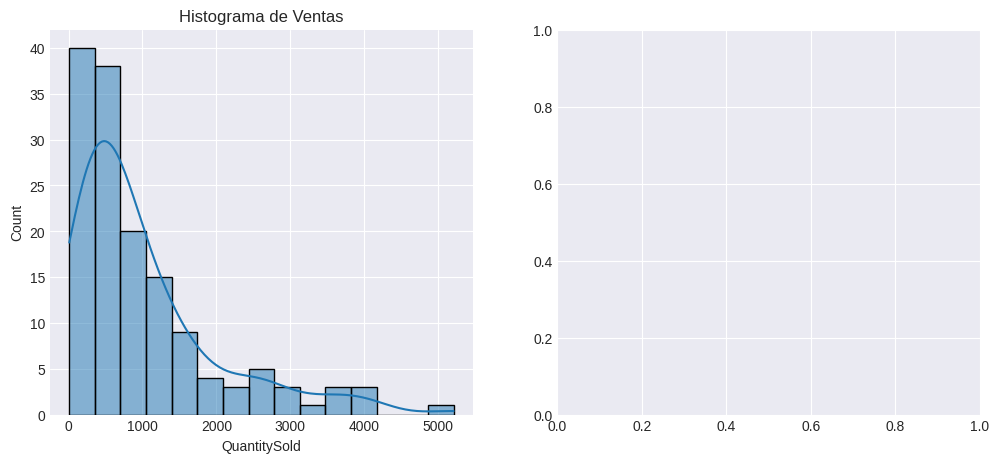

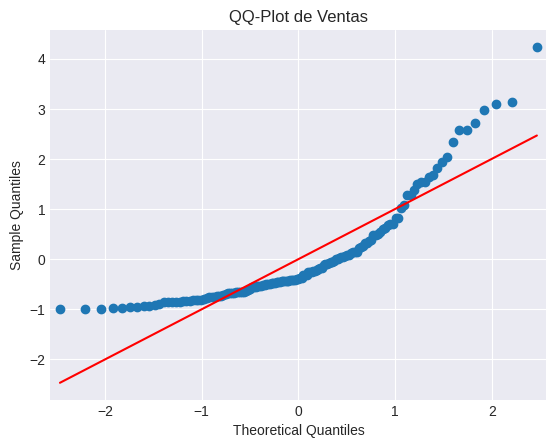

La serie NO es normal. Aplicando Box-Cox...
Lambda de Box-Cox: 0.21182109954163944


In [36]:
# comprobar la normalidad

from scipy.stats import shapiro, ks_2samp
from scipy.stats import norm
import statsmodels.api as sm

residuos = sales['QuantitySold']

# Test de Kolmogorov-Smirnov
ks_stat, p_ks = ks_2samp(residuos, norm.rvs(size=len(residuos)))
# Test de Shapiro-Wilk (para n < 5000)
shapiro_stat, p_shapiro = shapiro(residuos) if len(residuos) < 5000 else (None, None)

print(f"p-value Kolmogorov-Smirnov: {p_ks}")
print(f"p-value Shapiro-Wilk: {p_shapiro}")

# Histograma y QQ-Plot para ver distribución
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(residuos, kde=True)
plt.title("Histograma de Ventas")

plt.subplot(122)
sm.qqplot(residuos, line='s', fit=True)
plt.title("QQ-Plot de Ventas")
plt.show()

# Si p-valor < 0.05 en ambos test, la serie no es normal -> aplicar Box-Cox
if p_ks < 0.05 or (p_shapiro is not None and p_shapiro < 0.05):
    print("La serie NO es normal. Aplicando Box-Cox...")
    sales['QuantitySold'] = sales['QuantitySold'] + 1e-6
    sales['QuantitySold'], lambda_bc = boxcox(sales['QuantitySold'])
    print(f"Lambda de Box-Cox: {lambda_bc}")
else:
    print("La serie es normal. No es necesario aplicar Box-Cox.")

p-value Kolmogorov-Smirnov: 6.228200420741317e-84
p-value Shapiro-Wilk: 0.7285858794710836


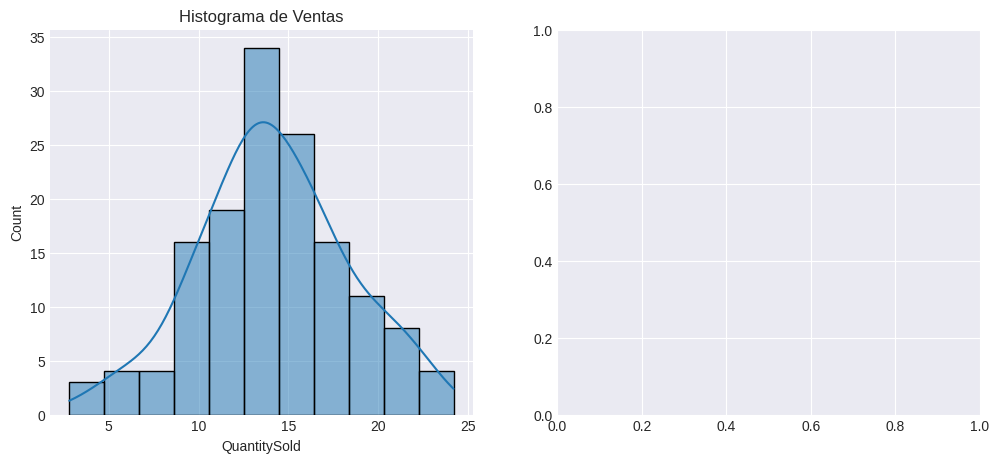

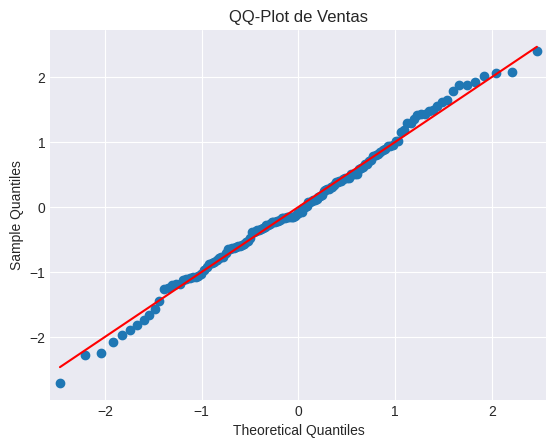

In [37]:
ks_stat, p_ks = ks_2samp(sales['QuantitySold'], norm.rvs(size=len(residuos)))
# Test de Shapiro-Wilk (para n < 5000)
shapiro_stat, p_shapiro = shapiro(sales['QuantitySold']) if len(sales['QuantitySold']) < 5000 else (None, None)

print(f"p-value Kolmogorov-Smirnov: {p_ks}")
print(f"p-value Shapiro-Wilk: {p_shapiro}")

# Histograma y QQ-Plot para ver distribución
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(sales['QuantitySold'], kde=True)
plt.title("Histograma de Ventas")

plt.subplot(122)
sm.qqplot(sales['QuantitySold'], line='s', fit=True)
plt.title("QQ-Plot de Ventas")
plt.show()

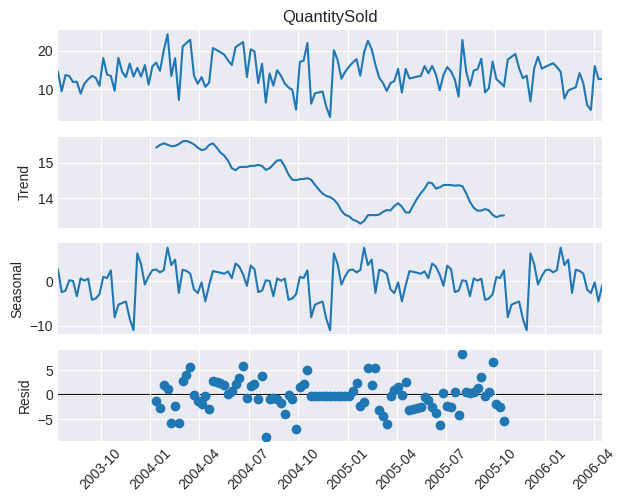

In [38]:
# descomposicion de la serie temporal

descomposicion = sm.tsa.seasonal_decompose(sales['QuantitySold'], model='additive')
descomposicion.plot()
plt.xticks(rotation = 45)
plt.show()

In [136]:
#train = round(len(sales)*0.9)
train = round(len(sales)*0.8)

train_data = sales[:int(train)]['QuantitySold']
test_data = sales[int(train):]['QuantitySold']
train_data.shape, test_data.shape

((116,), (29,))

In [137]:
train

116

In [138]:
train_data, test_data

(OrderDate
 2003-07-14    14.563659
 2003-07-21     9.461283
 2003-07-28    13.670811
 2003-08-04    13.403539
 2003-08-11    11.846838
                 ...    
 2005-08-29    15.142153
 2005-09-05    17.878629
 2005-09-12     9.184370
 2005-09-19    10.230842
 2005-09-26    17.152617
 Freq: W-MON, Name: QuantitySold, Length: 116, dtype: float64,
 OrderDate
 2005-10-03    12.579552
 2005-10-10    11.737891
 2005-10-17    10.696645
 2005-10-24    17.653413
 2005-10-31    18.410483
 2005-11-07    19.085205
 2005-11-14    15.429730
 2005-11-21    12.835318
 2005-11-28    13.522675
 2005-12-05     6.818743
 2005-12-12    15.407098
 2005-12-19    18.409131
 2005-12-26    15.310999
 2006-01-02    15.817588
 2006-01-09    16.281542
 2006-01-16    16.710224
 2006-01-23    15.741329
 2006-01-30    14.467022
 2006-02-06     7.553345
 2006-02-13     9.640600
 2006-02-20    10.091336
 2006-02-27    10.496149
 2006-03-06    14.177188
 2006-03-13    11.476093
 2006-03-20     5.901810
 2006-03-27    

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -8.586430304560244, p-value: 7.485650985904334e-14
KPSS Statistic: 0.21709007747571005, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -7.82974661338283, p-value: 6.33963522076335e-12
KPSS Statistic: 0.11587572176872668, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -9.113073136455942, p-value: 3.3586051946806782e-15
KPSS Statistic: 0.11401534421691069, p-value: 0.1


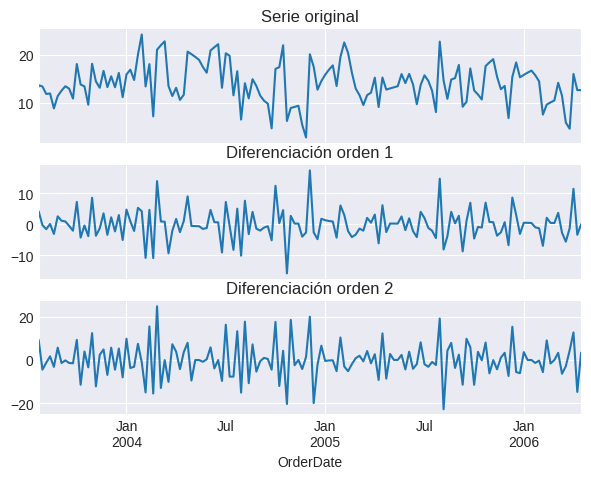

In [139]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = sales['QuantitySold'].diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(sales['QuantitySold'])
kpss_result = kpss(sales['QuantitySold'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(sales['QuantitySold'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(sales['QuantitySold'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
sales['QuantitySold'].plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

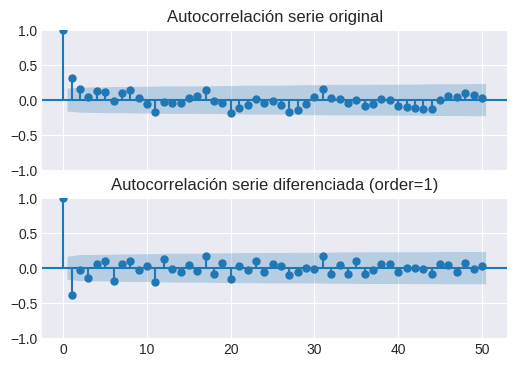

In [140]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(sales['QuantitySold'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

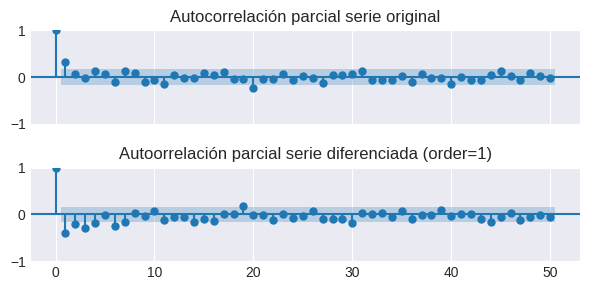

In [141]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(sales['QuantitySold'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

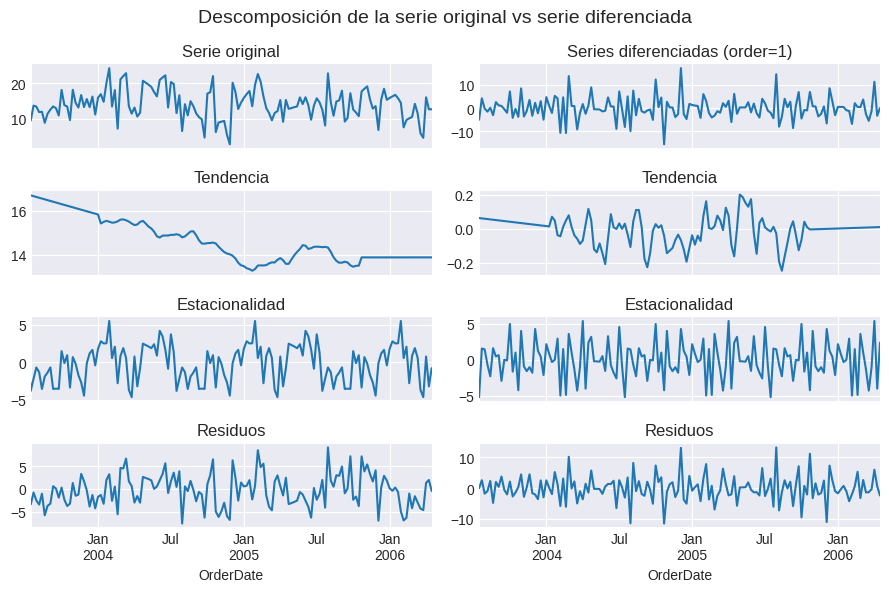

In [142]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(sales['QuantitySold'], model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

se sugiere una estacionalidad anual.

In [143]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = train_data.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -5.003195323257875, p-value: 2.187225373463384e-05
KPSS Statistic: 0.055064428790904923, p-value: 0.1


In [150]:
modelo_autoarima = auto_arima(train_data, seasonal=True, m=12, trace=True, suppress_warnings=True)
modelo_autoarima.fit_predict(test_data)

print(f"Mejor modelo sugerido por auto_arima: {modelo_autoarima.order}, {modelo_autoarima.seasonal_order}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=664.637, Time=1.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=669.098, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=663.339, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=665.330, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=959.209, Time=0.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=661.354, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=663.336, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=664.405, Time=1.18 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=662.375, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=662.380, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=663.417, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=663.998, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=710.266, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 4.899 seconds
Mejor modelo sugerido por auto_arima: (1, 0, 0), (0, 0, 0, 12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AIC: 159.12142357392023
BIC: 163.22331106387963
HQIC: 160.4060835613993
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -76.561
Date:                Sat, 22 Feb 2025   AIC                            159.121
Time:                        11:12:38   BIC                            163.223
Sample:                    10-03-2005   HQIC                           160.406
                         - 04-17-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.5520      1.871      4.037      0.000       3.885      11.219
ar.L1          0.4257      0.159      2.671      0.008     

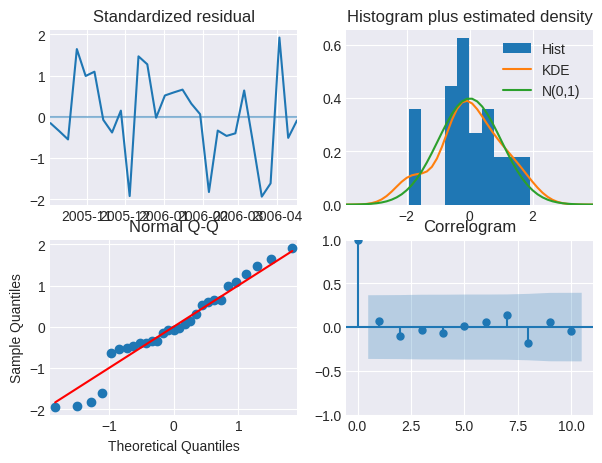

In [151]:
print(f"AIC: {modelo_autoarima.aic()}")
print(f"BIC: {modelo_autoarima.bic()}")
print(f"HQIC: {modelo_autoarima.hqic()}")
print(modelo_autoarima.summary())
modelo_autoarima.plot_diagnostics(figsize=(7,5))
plt.show()



In [152]:
modelo_autoarima.predict()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0
2006-04-24,12.934288
2006-05-01,13.058358
2006-05-08,13.111177
2006-05-15,13.133662
2006-05-22,13.143235
2006-05-29,13.147310
2006-06-05,13.149045
2006-06-12,13.149784
2006-06-19,13.150098
2006-06-26,13.150232


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


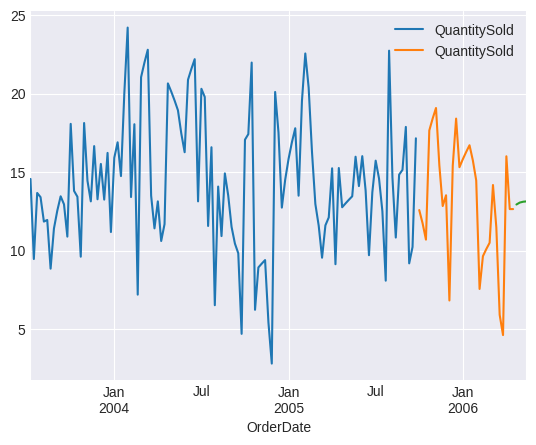

In [157]:
train_data.plot()
test_data.plot()
modelo_autoarima.predict(n_periods=4).plot()
plt.legend()
plt.show()

In [158]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = train_data, order = (1, 0, 0), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         QuantitySold   No. Observations:                  116
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -309.683
Date:                              Sat, 22 Feb 2025   AIC                            627.366
Time:                                      11:13:55   BIC                            637.944
Sample:                                  07-14-2003   HQIC                           631.651
                                       - 09-26-2005                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3070      0.080      3.819      0.000       0.149       0.464
ar.S.L12       0.0314      0.139      0.226      0.821      -0.241       0.304
ma.S.L12      -0.9973     13.834     -0.072      0.943     -28.112      26.118
sigma2        17.5307    240.703      0.073      0.942    -454.238     489.299
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.77   Prob(JB):                         0.56
Heteroskedasticity (H):               0.93   Skew:                            -0.11
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

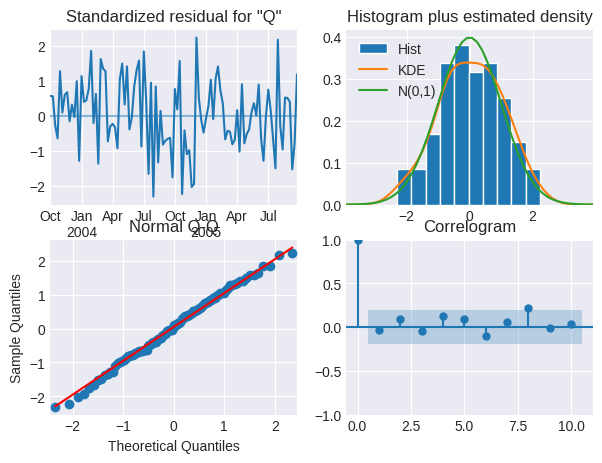

In [180]:
modelo_res.plot_diagnostics(figsize=(7,5))
plt.show()

In [298]:
modelo_res.get_prediction(start=len(train_data), end=len(train_data)+len(test_data)-1).summary_frame(alpha=0.05)

QuantitySold,mean,mean_se,mean_ci_lower,mean_ci_upper
2005-10-03,14.306173,4.405895,5.670778,22.941568
2005-10-10,14.971213,4.608771,5.938188,24.004238
2005-10-17,14.584215,4.627246,5.514981,23.653450
2005-10-24,16.493529,4.627050,7.424678,25.562380
2005-10-31,13.801169,4.606468,4.772659,22.829680
2005-11-07,14.178752,4.606483,5.150211,23.207292
2005-11-14,13.850519,4.606484,4.821975,22.879062
2005-11-21,12.768411,4.606484,3.739868,21.796955
2005-11-28,15.701485,4.606484,6.672942,24.730029
2005-12-05,14.507887,4.606484,5.479343,23.536430


In [299]:
# Realizar predicciones con intervalos de confianza
predicciones = modelo_res.get_prediction(start=len(train_data), end=len(train_data) + len(test_data) - 1)
predicciones_summary = predicciones.summary_frame(alpha=0.05)

# Extraer predicciones, intervalos inferior y superior
predicted_mean = predicciones_summary['mean']
predicted_ci_lower = predicciones_summary['mean_ci_lower']
predicted_ci_upper = predicciones_summary['mean_ci_upper']

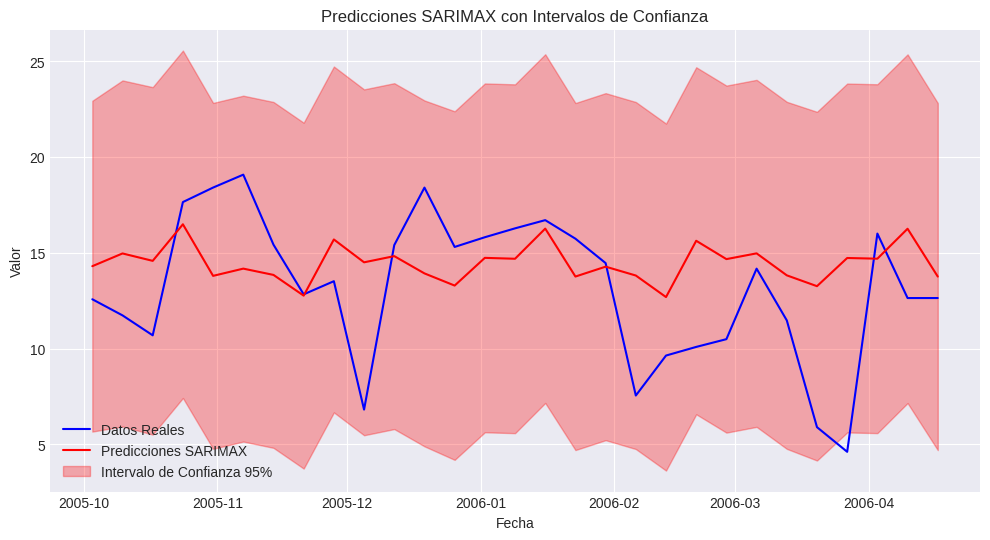

In [300]:
# Graficar las predicciones y los intervalos de confianza
plt.figure(figsize=(12, 6))

# Graficar los datos reales de prueba
plt.plot(test_data.index, test_data, label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(test_data.index, predicted_mean, label='Predicciones SARIMAX', color='red')

# Graficar los intervalos de confianza
plt.fill_between(test_data.index, predicted_ci_lower, predicted_ci_upper, color='red', alpha=0.3, label='Intervalo de Confianza 95%')

# Configurar las etiquetas y el título
plt.title('Predicciones SARIMAX con Intervalos de Confianza')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Mostrar la gráfica
plt.show()


In [301]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(test_data)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

,predicciones_statsmodels
2005-10-03,14.306173
2005-10-10,14.971213
2005-10-17,14.584215
2005-10-24,16.493529


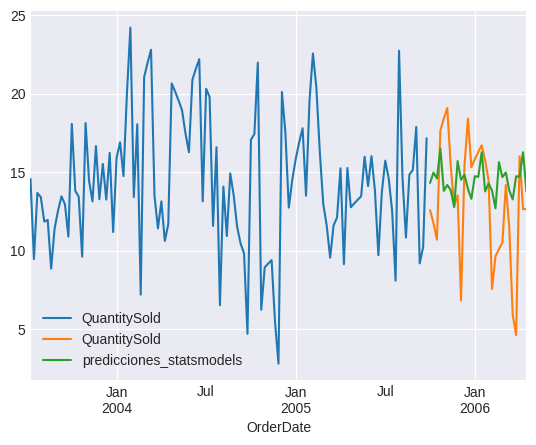

In [302]:
train_data.plot()
test_data.plot()
predicciones_statsmodels.plot()
plt.legend()
plt.show()


In [161]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(2, 0, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=train_data)
modelo.summary()
warnings.filterwarnings("default")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [305]:
# Modelo ARIMA
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
resultado = modelo.fit(y=train_data)
modelo.summary()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -309.507
Date:                            Sat, 22 Feb 2025   AIC                            631.015
Time:                                    12:16:13   BIC                            646.823
Sample:                                07-14-2003   HQIC                           637.418
                                     - 09-26-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0109      0.021     -0.526      0.599      -0.052       0.030
ar.L1          0.2201      0.132      1.671      0.095      -0.038       0.478
ma.L1         -0.9038      0.058    -15.528      0.000      -1.018      -0.790
ar.S.L12      -0.0042      0.162     -0.026      0.979      -0.323       0.314
ma.S.L12      -0.9994     66.242     -0.015      0.988    -130.831     128.832
sigma2        17.9945   1190.159      0.015      0.988   -2314.674    2350.663
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.78   Prob(JB):                         0.94
Heteroskedasticity (H):               1.01   Skew:                            -0.07
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [306]:
modelo.conf_int()

,0,1
intercept,-0.051679,0.029822
ar.L1,-0.038070,0.478237
ma.L1,-1.017858,-0.789707
ar.S.L12,-0.322546,0.314165
ma.S.L12,-130.830523,128.831770
sigma2,-2314.673623,2350.662540


In [172]:
residuos = resultado.resid()
residuos

,0
OrderDate,
2003-07-14,14.577613
2003-07-21,-5.088270
2003-07-28,4.223410
2003-08-04,-0.253246
2003-08-11,-1.542736
...,...
2005-08-29,3.206158
2005-09-05,2.321085
2005-09-12,-6.440528


In [174]:

import scipy.stats as stats


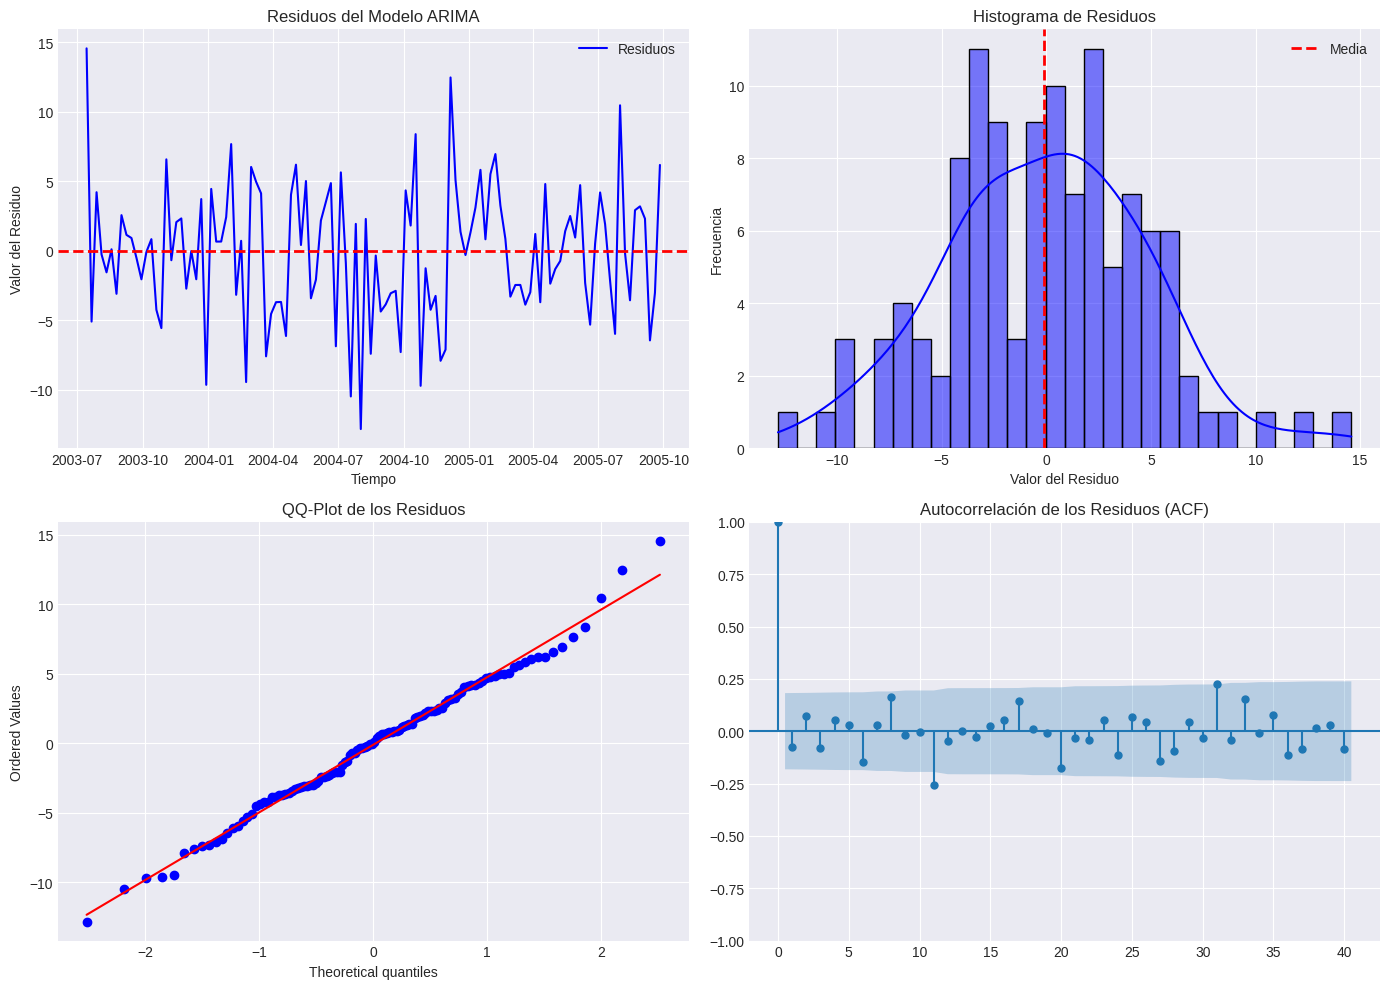

In [175]:
residuos = resultado.resid()

# Crear figura con 4 subgráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Serie de residuos en el tiempo
axes[0, 0].plot(residuos, label="Residuos", color="blue")
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title("Residuos del Modelo ARIMA")
axes[0, 0].set_xlabel("Tiempo")
axes[0, 0].set_ylabel("Valor del Residuo")
axes[0, 0].legend()

# 2. Histograma de residuos
sns.histplot(residuos, kde=True, bins=30, color="blue", ax=axes[0, 1])
axes[0, 1].axvline(x=residuos.mean(), color='red', linestyle='dashed', linewidth=2, label="Media")
axes[0, 1].set_title("Histograma de Residuos")
axes[0, 1].set_xlabel("Valor del Residuo")
axes[0, 1].set_ylabel("Frecuencia")
axes[0, 1].legend()

# 3. QQ-Plot de residuos
stats.probplot(residuos, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("QQ-Plot de los Residuos")

# 4. ACF de los residuos
plot_acf(residuos, ax=axes[1, 1], lags=40)
axes[1, 1].set_title("Autocorrelación de los Residuos (ACF)")

plt.tight_layout()
plt.show()

In [176]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(test_data))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,predicciones_pdmarima
2005-10-03,13.197752
2005-10-10,13.924612
2005-10-17,13.714017
2005-10-24,15.113997


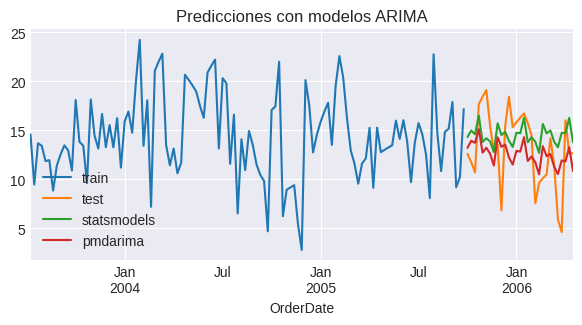

In [177]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
train_data.plot(ax=ax, label='train')
test_data.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
#predicciones_skforecast.columns = ['skforecast']
#predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();

In [186]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=train_data, suppress_warnings=True)
forecaster.summary()

# Predicción
predicciones = forecaster.predict(steps=len(test_data))
predicciones.head(4)

ForecasterSarimax 
Regressor: Sarimax(1,1,1)(1,1,1)[12] 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('2003-07-14 00:00:00'), Timestamp('2005-09-26 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-MON 
Regressor parameters: 
    {'concentrate_scale': False, 'dates': None, 'disp': False,
    'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None,
    'hamilton_representation': False, 'maxiter': 50, 'measurement_error': False,
    'method': 'lbfgs', 'missing': 'none', 'mle_regression': True, 'order': (1,
    1, 1), 'seasonal_order': (1, 1, 1, 12), 'simple_differencing': False,
    'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {},
    'start_params': None, 'time_varying_regression': False, 'trend': None,
    'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification':
    True} 
fit_kwargs: {} 
Creation date: 2025-02-22 11:23:08 

,pred
2005-10-03,13.671122
2005-10-10,14.584502
2005-10-17,14.479018
2005-10-24,15.924509


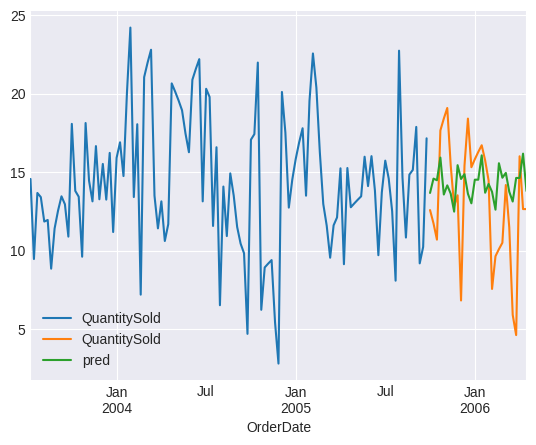

In [182]:
train_data.plot()
test_data.plot()
predicciones.plot()
plt.legend()
plt.show()


In [195]:
modelo_ajustado = forecaster.regressor
modelo_ajustado.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       QuantitySold   No. Observations:                  116
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -309.679
Date:                            Sat, 22 Feb 2025   AIC                            629.359
Time:                                    11:28:30   BIC                            642.532
Sample:                                07-14-2003   HQIC                           634.695
                                     - 09-26-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2133      0.133      1.604      0.109      -0.047       0.474
ma.L1         -0.8913      0.059    -15.042      0.000      -1.007      -0.775
ar.S.L12      -0.0059      0.159     -0.037      0.971      -0.317       0.305
ma.S.L12      -0.9998    163.955     -0.006      0.995    -322.346     320.347
sigma2        18.0766   2961.962      0.006      0.995   -5787.262    5823.415
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.74   Prob(JB):                         0.95
Heteroskedasticity (H):               1.01   Skew:                            -0.05
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [204]:
pred_interval = forecaster.predict_interval(steps=len(test_data))
pred_interval

,pred,lower_bound,upper_bound
2005-10-03,13.671122,4.884676,22.457569
2005-10-10,14.584502,5.352541,23.816464
2005-10-17,14.479018,5.115631,23.842405
2005-10-24,15.924509,6.471696,25.377322
2005-10-31,13.570136,4.055487,23.084784
2005-11-07,14.153756,4.562311,23.745200
2005-11-14,13.625090,3.957792,23.292387
2005-11-21,12.481330,2.738841,22.223819
2005-11-28,15.440373,5.623284,25.257463
2005-12-05,14.561713,4.670588,24.452838


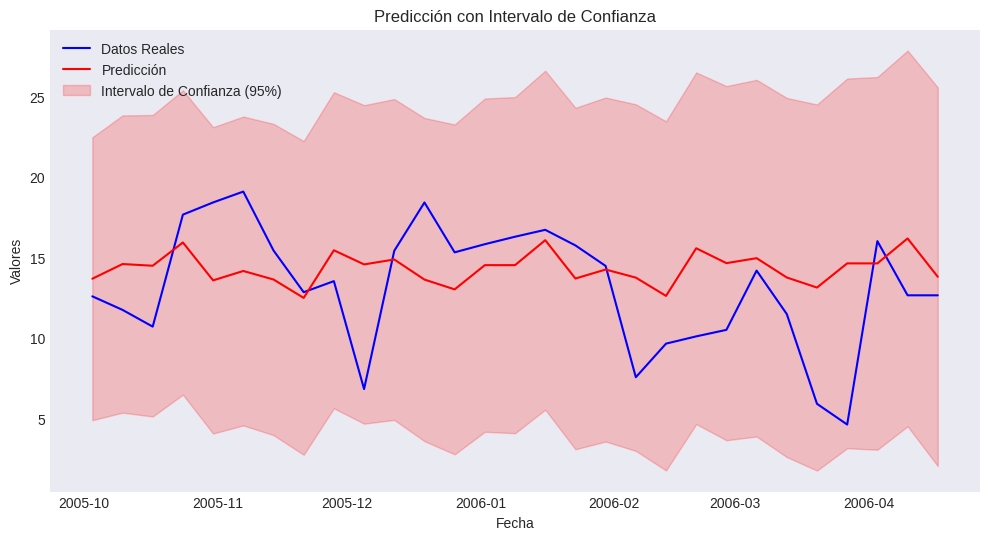

In [205]:
plt.figure(figsize=(12, 6))

# Datos reales
plt.plot(test_data.index, test_data, label="Datos Reales", color="blue")

# Predicciones
plt.plot(pred_interval.index, pred_interval["pred"], label="Predicción", color="red")

# Rellenar el intervalo de confianza
plt.fill_between(pred_interval.index,
                 pred_interval["lower_bound"],
                 pred_interval["upper_bound"],
                 color='red', alpha=0.2, label="Intervalo de Confianza (95%)")

plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title("Predicción con Intervalo de Confianza")
plt.legend()
plt.grid()
plt.show()

In [207]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(train_data),
        refit              = True,
        fixed_train_size   = False,
)
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = y,
                            cv                    = cv,
                            metric                = 'mean_absolute_error',
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )
display(metrica)
display(predicciones.head(4))

Information of folds
--------------------
Number of observations used for initial training: 116
Number of observations used for backtesting: 29
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 5 observations.

Fold: 0
    Training:   2003-07-14 00:00:00 -- 2005-09-26 00:00:00  (n=116)
    Validation: 2005-10-03 00:00:00 -- 2005-12-19 00:00:00  (n=12)
Fold: 1
    Training:   2003-07-14 00:00:00 -- 2005-12-19 00:00:00  (n=128)
    Validation: 2005-12-26 00:00:00 -- 2006-03-13 00:00:00  (n=12)
Fold: 2
    Training:   2003-07-14 00:00:00 -- 2006-03-13 00:00:00  (n=140)
    Validation: 2006-03-20 00:00:00 -- 2006-04-17 00:00:00  (n=5)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_absolute_error
0,2.978622


,pred
2005-10-03,13.671122
2005-10-10,14.584502
2005-10-17,14.479018
2005-10-24,15.924509


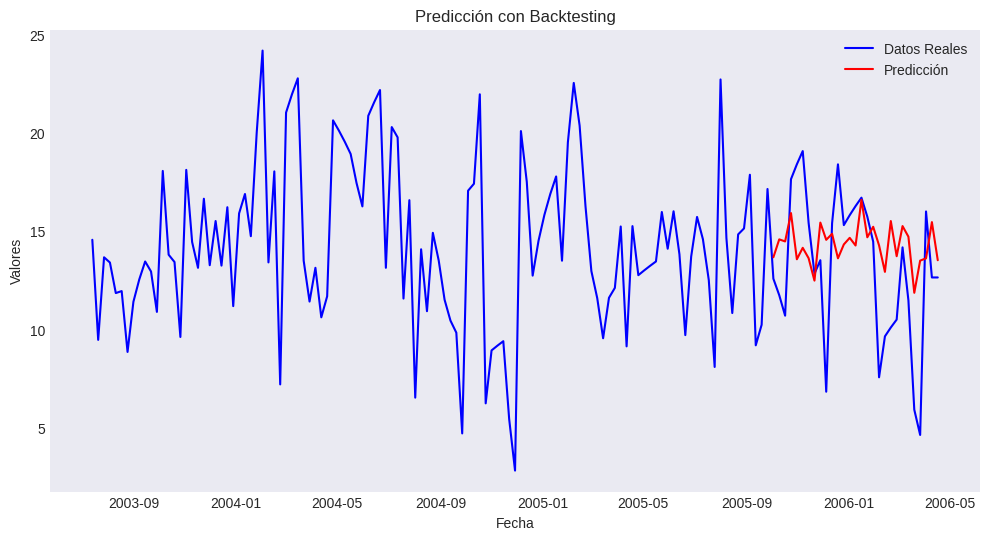

In [212]:
plt.figure(figsize=(12, 6))

# Datos reales
plt.plot(y.index, y, label="Datos Reales", color="blue")
plt.plot(predicciones.index, predicciones, label="Predicción", color="red")

plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title("Predicción con Backtesting")
plt.legend()
plt.grid()
plt.show()

In [219]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=3)


In [270]:
import contextlib
from sklearn.metrics import mean_absolute_error

def backtesting_sarimax_enhanced(
    forecaster, y, cv, metric,
    n_jobs="auto", suppress_warnings_fit=True, verbose=True, show_progress=True, test_size=0.3
):
    """
    Enhanced backtesting for Sarimax models to include AIC, BIC, and residuals,
    with an option to select the last `test_size` percentage of data for predictions.
    """

    metric_values = []
    predictions_list = []
    fitted_models = []  # Store fitted models
    residuals_list = []  # Store residuals
    index_list = []  # Store all test indices

    # Calculate the index for the start of the test set (last 30% of the data)
    test_index_start = int(len(y) * (1 - test_size))

    # Track the test indices for the last 30% of the data
    for split in cv.split(y):
        # Check the length of split
        if len(split) == 2:  # Standard case: only train and test indices
            train_index, test_index = split
        elif len(split) > 2:  # Case where more than 2 elements are returned (e.g., windows)
            train_index, test_index, _ = split  # Discard extra values
        else:
            raise ValueError("cv.split(y) returned an unexpected number of values")

        # Make sure the test data is within the last 30% of the data
        if test_index[0] >= test_index_start:
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Fit the model with suppress_warnings_fit if enabled
            with contextlib.suppress(Exception) if suppress_warnings_fit else contextlib.nullcontext():
                forecaster.fit(y=y_train)

            # Store the fitted model
            fitted_models.append(forecaster.regressor)

            # Predict and store predictions
            predictions = forecaster.predict(steps=len(y_test))
            predictions_list.extend(predictions.tolist())

            # Calculate and store residuals
            residuals = y_test - predictions
            residuals_list.extend(residuals.tolist())

            # Store the test indices
            index_list.extend(test_index)

            # Calculate the specified metric and store it
            metric_value = metric(y_test, predictions)
            metric_values.append(metric_value)
        else:
            print("Skipping fold as test set is outside the last 30% of data")

    # Create a DataFrame for predictions with index aligned with y
    predictions_df = pd.DataFrame(predictions_list, index=y.iloc[index_list].index)  # Use the collected indices
    predictions_df.columns = ['pred']

    # Create a DataFrame for residuals
    residuals_df = pd.DataFrame(residuals_list, index=y.iloc[index_list].index)  # Use the collected indices
    residuals_df.columns = ['resid']

    return metric_values, predictions_df, fitted_models, residuals_df



In [281]:
# Backtest forecaster with enhanced function
metrica, predicciones, fitted_models, residuals_df = backtesting_sarimax_enhanced(
    forecaster=forecaster,
    y=y,
    cv=cv,
    metric=mean_absolute_error,  # Or any other metric from skforecast.metrics
    n_jobs="auto",
    suppress_warnings_fit=True,
    verbose=True,
    show_progress=True,
    test_size = 0.3
)



Skipping fold as test set is outside the last 30% of data
Skipping fold as test set is outside the last 30% of data


In [282]:
metrica

[3.2729181151026348]

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

def plot_residuals(residuals_df, predictions_df):
    """
    Plots the residuals, QQ plot, histogram, and residuals vs predictions graph.
    """

    # 1. Residuos vs Predicciones
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions_df.index, residuals_df['resid'], color='blue', label='Residuos')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuos vs Predicciones')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.legend()
    plt.show()

    # 2. Histograma de residuos
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals_df['resid'], bins=30, kde=True, color='skyblue')
    plt.title('Histograma de Residuos')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.show()

    # 3. QQ plot de los residuos
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals_df['resid'], dist="norm", plot=plt)
    plt.title('QQ Plot de Residuos')
    plt.show()





Longitud de residuos: 36
Longitud de predicciones: 36


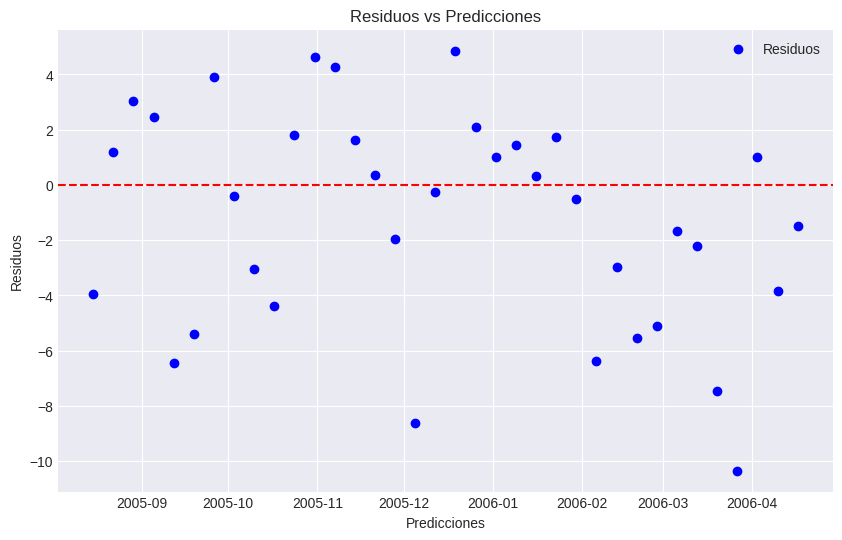

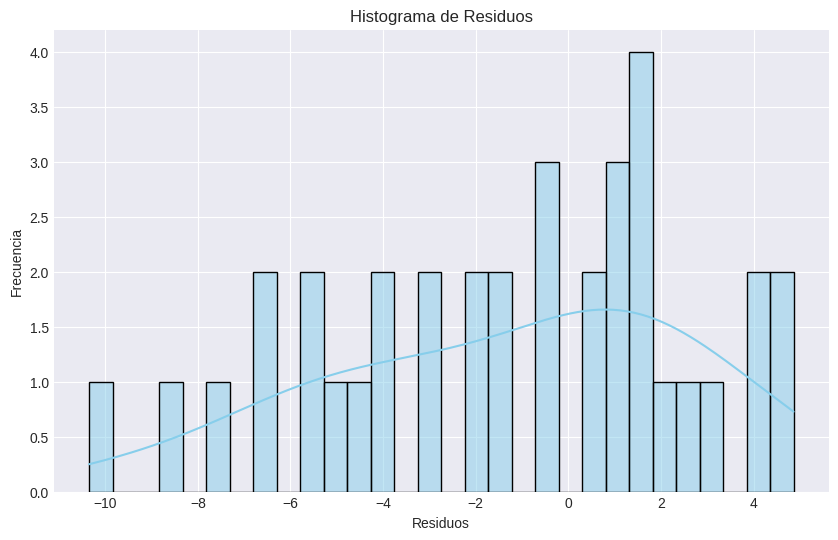

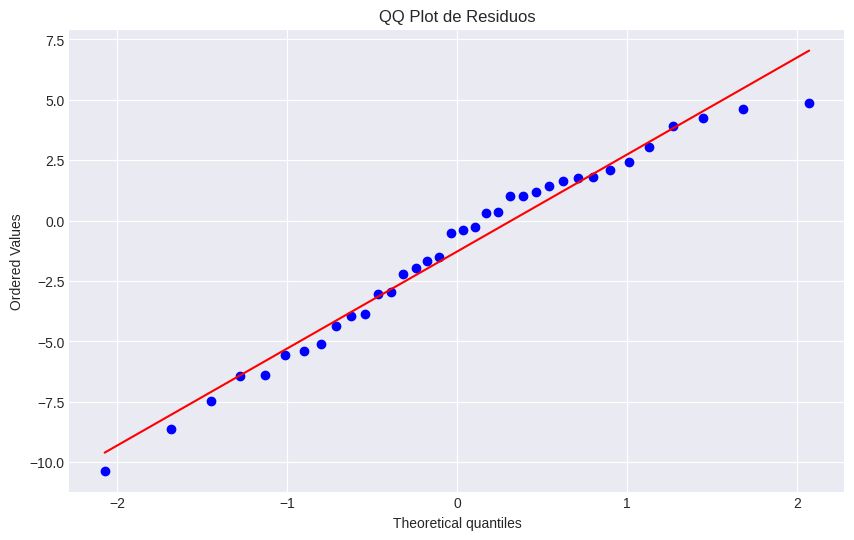

In [292]:
# Verifica la longitud de los DataFrames
print("Longitud de residuos:", len(residuals_df))
print("Longitud de predicciones:", len(predicciones))

# Si las longitudes no coinciden, alinéalos
if len(residuals_df) != len(predicciones):
    # Alinea predicciones a los índices de residuals_df
    predicciones = predicciones.loc[residuals_df.index]

# Llamar a la función para graficar
plot_residuals(residuals_df, predicciones)


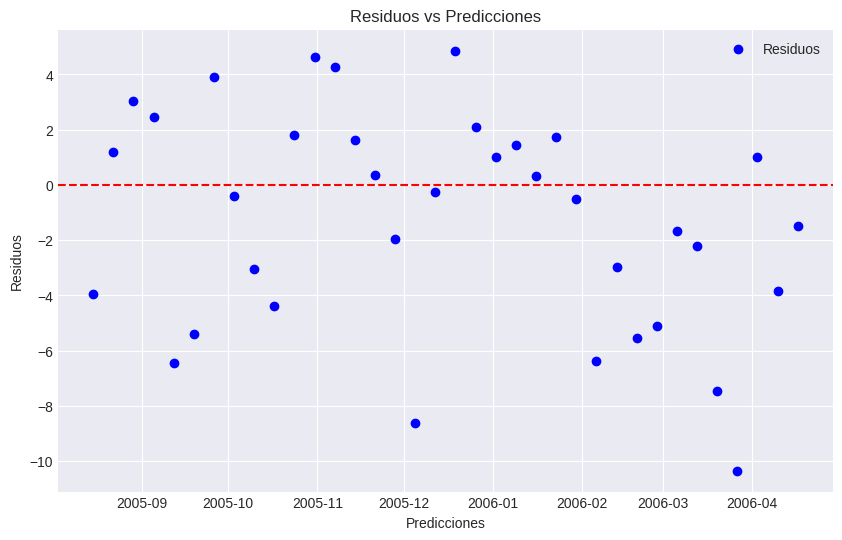

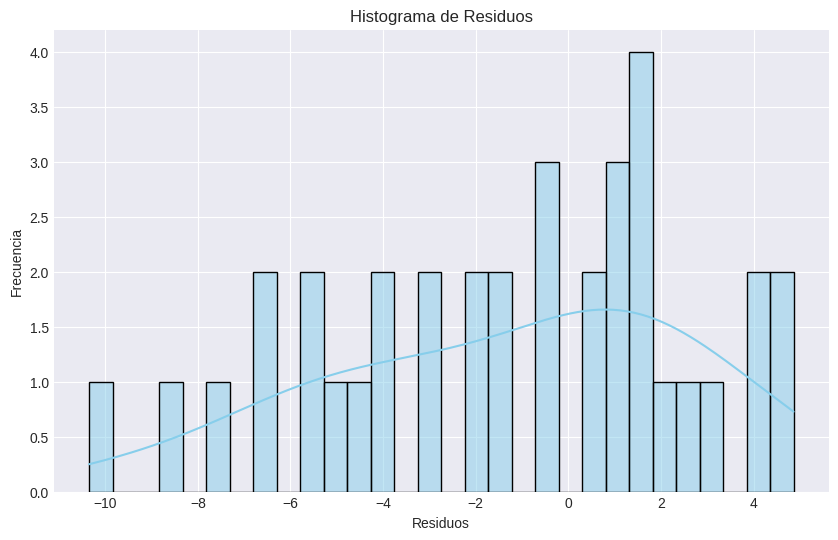

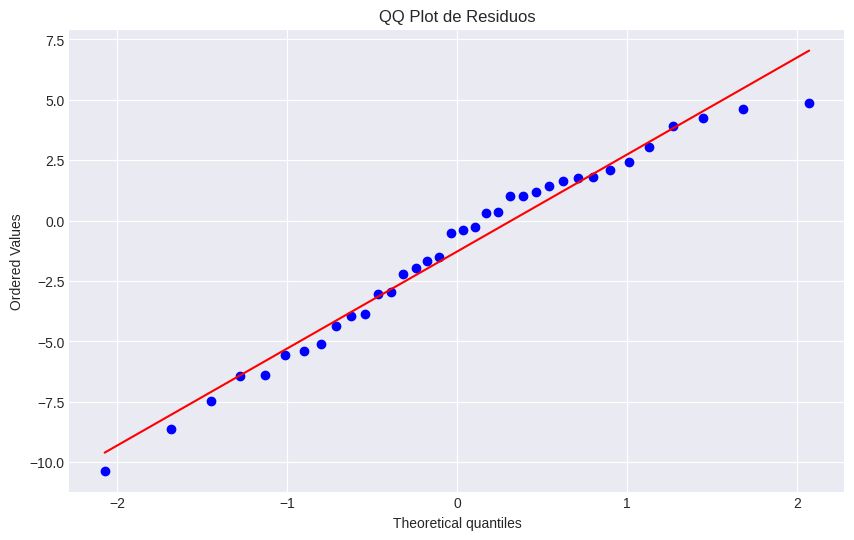

In [293]:
plot_residuals(residuals_df, predicciones)

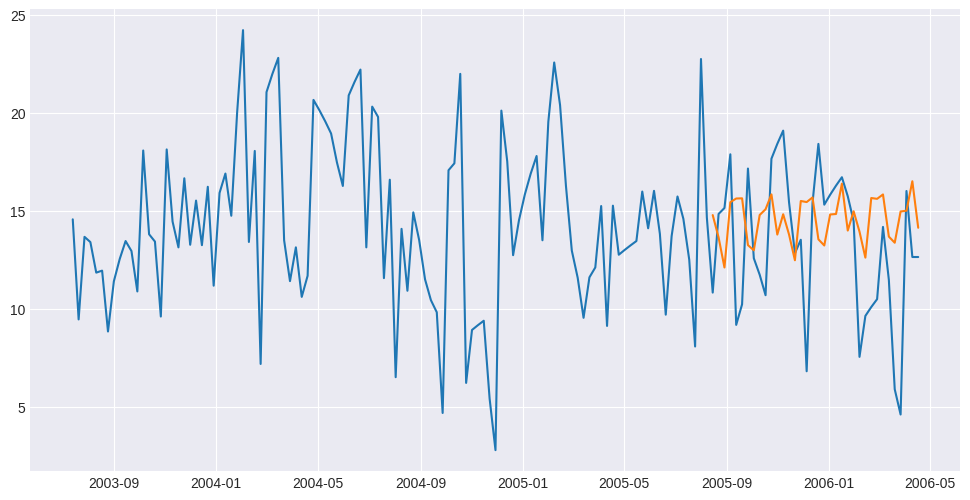

In [294]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.plot(predicciones)
plt.show()

In [119]:
train

130

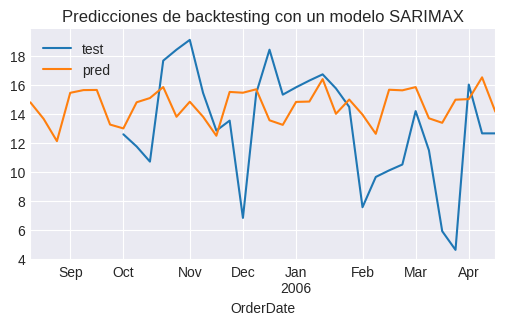

In [295]:
# prompt: me da este error: TypeError                                 Traceback (most recent call last)
# <ipython-input-97-d54808365062> in <cell line: 0>()
#       2 # ==============================================================================
#       3 fig, ax = plt.subplots(figsize=(6, 3))
# ----> 4 y.loc[train:].plot(ax=ax, label='test')
#       5 predicciones.plot(ax=ax)
#       6 ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
# 9 frames
# /usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py in _raise_invalid_indexer(self, form, key, reraise)
#    4299         if reraise is not lib.no_default:
#    4300             raise TypeError(msg) from reraise
# -> 4301         raise TypeError(msg)
#    4302
#    4303     # --------------------------------------------------------------------
# TypeError: cannot do slice indexing on DatetimeIndex with these indexers [102] of type int, aqui fig, ax = plt.subplots(figsize=(6, 3))
# y.loc[train:].plot(ax=ax, label='test')
# predicciones.plot(ax=ax)
# ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
# ax.legend();


# The error occurs because you are trying to use an integer (102) to slice a DatetimeIndex.
# `y.loc[train:]` is incorrect because `train` is an integer representing the index where the test set begins.
# You should use the DatetimeIndex values to slice the DataFrame

fig, ax = plt.subplots(figsize=(6, 3))
y.loc[y.index[train]:].plot(ax=ax, label='test') # Correct slicing using the index
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend();


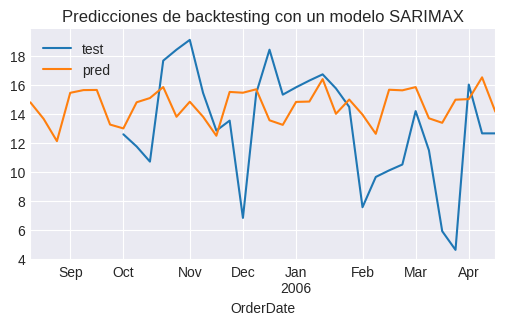

In [296]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
y.loc[y.index[train]:].plot(ax=ax, label='test') # Correct slicing using the index
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend();


In [123]:
sales

,QuantitySold,QuantitySold_no_out
OrderDate,,
2003-07-14,14.563659,768.0
2003-07-21,9.461283,180.0
2003-07-28,13.670811,614.0
2003-08-04,13.403539,573.0
2003-08-11,11.846838,375.0
...,...,...
2006-03-20,5.901810,46.0
2006-03-27,4.614672,25.0
2006-04-03,16.007824,1080.0


In [124]:
df = pd.merge(df_order_details, df_orders, on = 'OrderID')
df = pd.merge(df, df_products, on = 'ProductID')
df.head()

,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,...,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,2,2,955,5,7.5,37.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,997,XXL,Dozen,In Production,2003-07-10,7.15,PCL29
1,3,2,958,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1110,XXL,Dozen,In Production,2003-07-10,8.30,PCL31S
2,5,2,959,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1055,XXL,Dozen,In Production,2003-07-10,7.20,PCL31T
3,6,4,72,50,3.0,150.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,233,S,Dozen,In Production,2003-07-10,2.50,ERK61
4,7,4,9,50,3.2,160.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,325,M,Dozen,In Production,2003-07-10,2.70,ERK61


In [125]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df.dtypes

,0
OrderDetailID,int64
OrderID,int64
ProductID,int64
QuantitySold,int64
UnitSalesPrice,float64
total_price,float64
CustomerID,int64
EmployeeID,int64
ShippingMethodID,int64
OrderDate,datetime64[ns]


In [126]:
sales_ph = df.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
sales_ph

,OrderDate,QuantitySold
0,2003-07-10,145
1,2003-07-11,330
2,2003-07-14,768
3,2003-07-15,835
4,2003-07-16,540
...,...,...
741,2006-04-13,2044
742,2006-04-14,92
743,2006-04-18,147
744,2006-04-19,4145


In [310]:
sales_ph = sales_ph.rename(columns={'OrderDate': 'ds', 'QuantitySold': 'y'})

# Asegurar frecuencia diaria
sales_ph = sales_ph.set_index('ds').asfreq('W-MON').reset_index()

# Interpolación de valores faltantes
sales_ph['y'] = sales_ph['y'].interpolate()

df = sales_ph

In [311]:
q1 = df['y'].quantile(0.25)
q3 = df['y'].quantile(0.75)
iqr = q3 - q1  # Rango intercuartílico
limite_inf = q1 - 1.5 * iqr
limite_sup = q3 + 1.5 * iqr

outliers = df[(df['y'] < limite_inf) | (df['y'] > limite_sup)]
print(f"Se encontraron {len(outliers)} outliers.")

# Opcional: reemplazo de outliers con media o mediana
df['y'] = np.where((df['y'] < limite_inf) | (df['y'] > limite_sup),
                   df['y'].median(), df['y'])

Se encontraron 0 outliers.


Lambda de Box-Cox: 0.36171688384508016


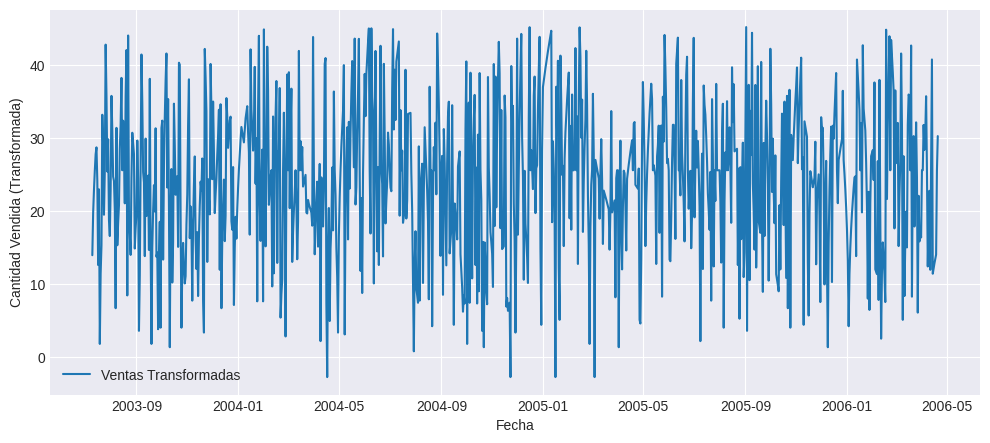

In [129]:
# --------------------------- TRANSFORMACIÓN BOX-COX ---------------------------
df['y'] = df['y'].apply(lambda x: x + 1e-6 if x <= 0 else x)
df['y'], lambda_bc = boxcox(df['y'])
print(f"Lambda de Box-Cox: {lambda_bc}")

# --------------------------- VISUALIZACIÓN DE LA SERIE ---------------------------
plt.figure(figsize=(12,5))
plt.plot(df['ds'], df['y'], label="Ventas Transformadas")
plt.xlabel("Fecha")
plt.ylabel("Cantidad Vendida (Transformada)")
plt.legend()
plt.show()



In [312]:
from prophet import Prophet


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg3f45vny/o4xvlgle.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg3f45vny/5njmvh0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41035', 'data', 'file=/tmp/tmpg3f45vny/o4xvlgle.json', 'init=/tmp/tmpg3f45vny/5njmvh0h.json', 'output', 'file=/tmp/tmpg3f45vny/prophet_modelwhv5dm3i/prophet_model-20250222122302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


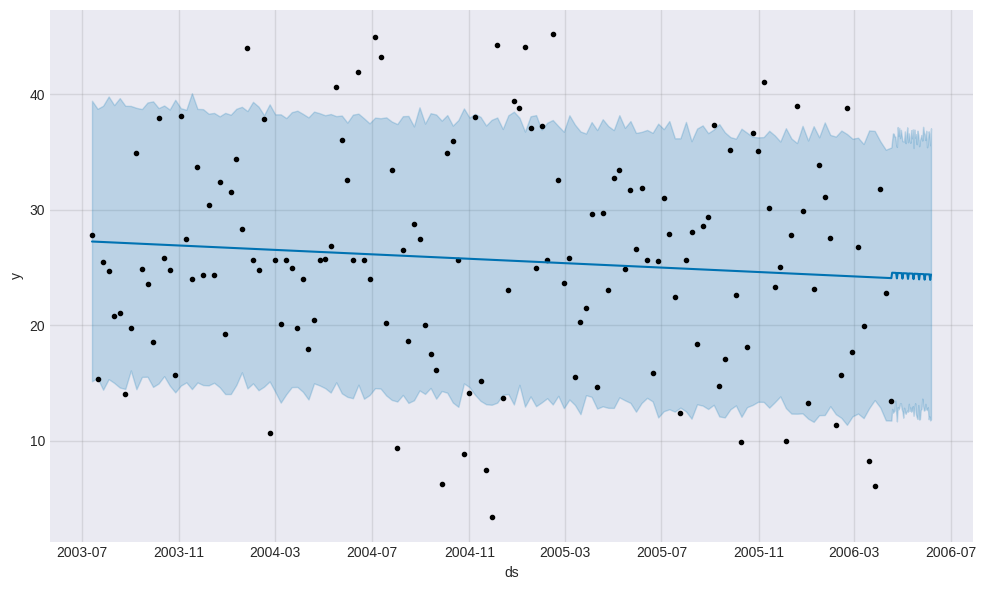

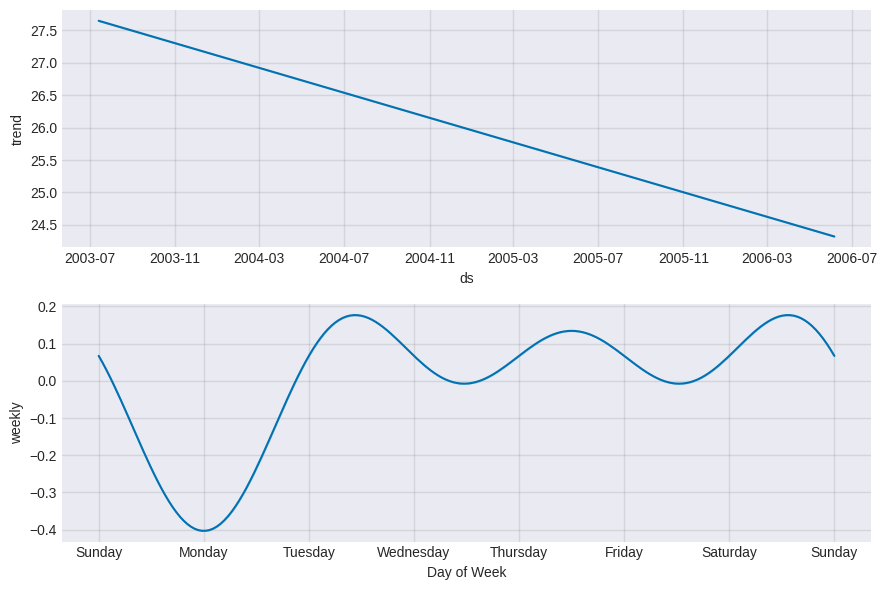

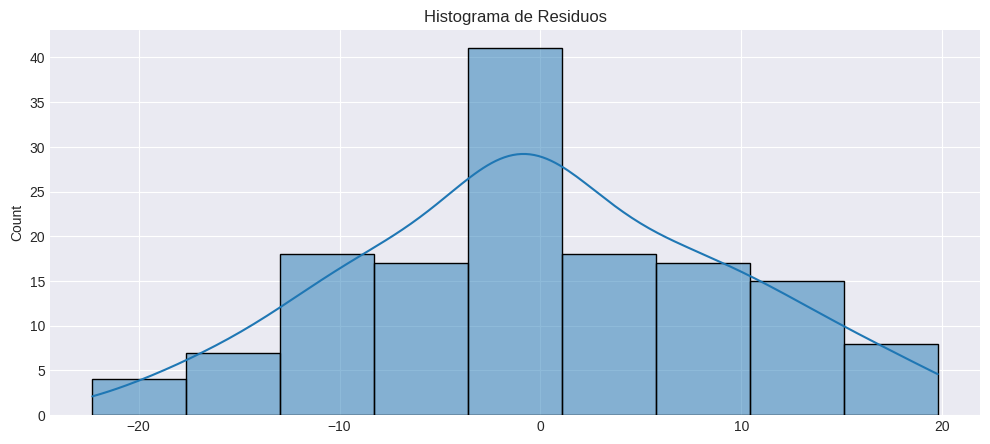

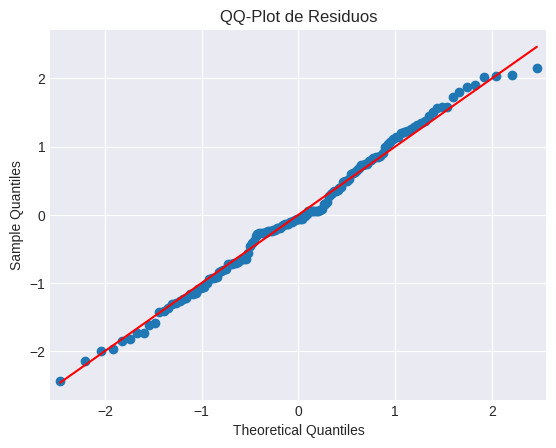

In [313]:
# --------------------------- CREACIÓN Y AJUSTE DEL MODELO CON PROPHET ---------------------------
modelo_prophet = Prophet(seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
modelo_prophet.fit(df)

# --------------------------- PREDICCIONES ---------------------------
# Crear un DataFrame con las fechas futuras para las que queremos hacer las predicciones
future = modelo_prophet.make_future_dataframe(periods=50, freq = 'D')

# Realizar las predicciones
forecast = modelo_prophet.predict(future)

# Visualizar las predicciones
modelo_prophet.plot(forecast)
plt.show()

# --------------------------- COMPONENTES DEL MODELO ---------------------------
modelo_prophet.plot_components(forecast)
plt.show()

# --------------------------- EVALUACIÓN DEL MODELO ---------------------------
# Evaluar los residuos
residuos = df['y'] - forecast['yhat'][:len(df)]

# Histograma de residuos
plt.figure(figsize=(12, 5))
sns.histplot(residuos, kde=True)
plt.title("Histograma de Residuos")
plt.show()

# QQ-Plot de residuos
import statsmodels.api as sm
sm.qqplot(residuos, line='s', fit=True)
plt.title("QQ-Plot de Residuos")
plt.show()


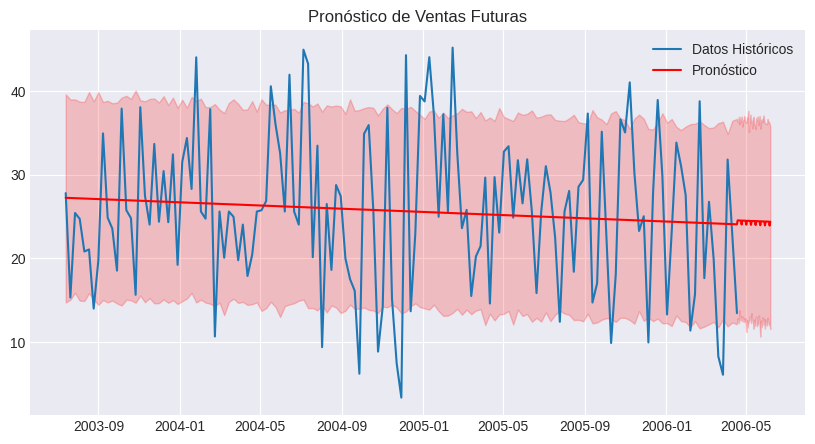

In [314]:
# Pronóstico para los siguientes 30 días
forecast_futuro = modelo_prophet.predict(future)
forecast_ci = forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Visualización de las predicciones a futuro
plt.figure(figsize=(10,5))
plt.plot(df['ds'], df['y'], label="Datos Históricos")
plt.plot(forecast_futuro['ds'], forecast_futuro['yhat'], label="Pronóstico", color='red')
plt.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Pronóstico de Ventas Futuras")
plt.show()


In [315]:
# Ajustar el modelo si es necesario
modelo_prophet = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,

)
modelo_prophet.fit(df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg3f45vny/s4plsvj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg3f45vny/i8gwtm3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6319', 'data', 'file=/tmp/tmpg3f45vny/s4plsvj6.json', 'init=/tmp/tmpg3f45vny/i8gwtm3j.json', 'output', 'file=/tmp/tmpg3f45vny/prophet_modelc1muj49u/prophet_model-20250222122318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [321]:
# Predicciones
future = modelo_prophet.make_future_dataframe(periods=0, freq='W')
forecast = modelo_prophet.predict(future)

# Calcular los residuos (diferencia entre los valores reales y las predicciones)
residuos = df['y'] - forecast['yhat'][:len(df)]

# Calcular log-verosimilitud (aproximación)
log_likelihood = -0.5 * np.sum((residuos / np.std(residuos))**2)

# Número de parámetros del modelo (típicamente 4 para Prophet: 1 para tendencia, 1 para estacionalidad y 2 para los parámetros de error)
k = 4

# Número de observaciones
n = len(df)

# Calcular AIC y BIC
aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic}")
print(f"BIC: {bic}")

AIC: 153.00211973929493
BIC: 164.90905470897724


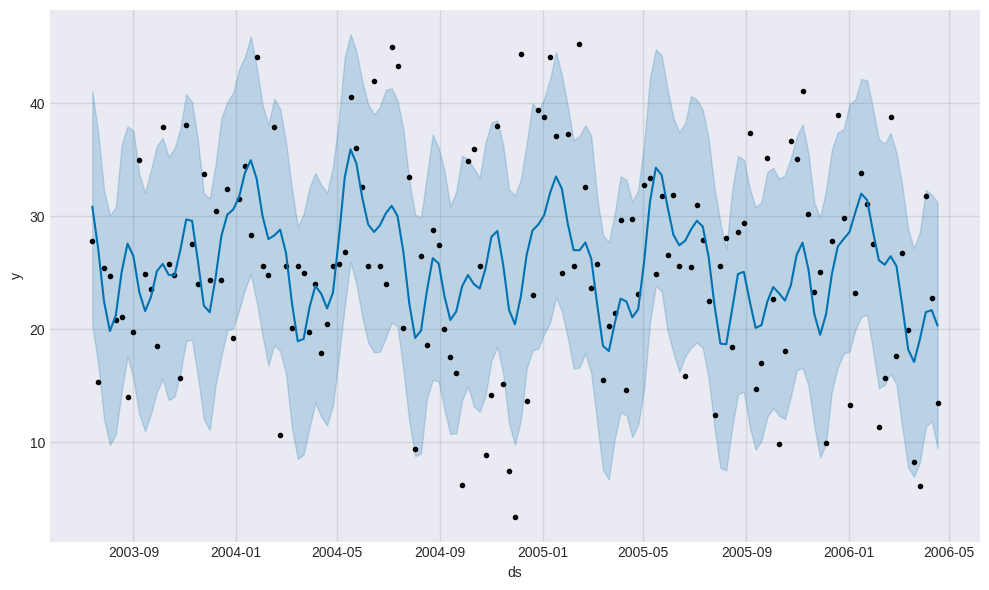

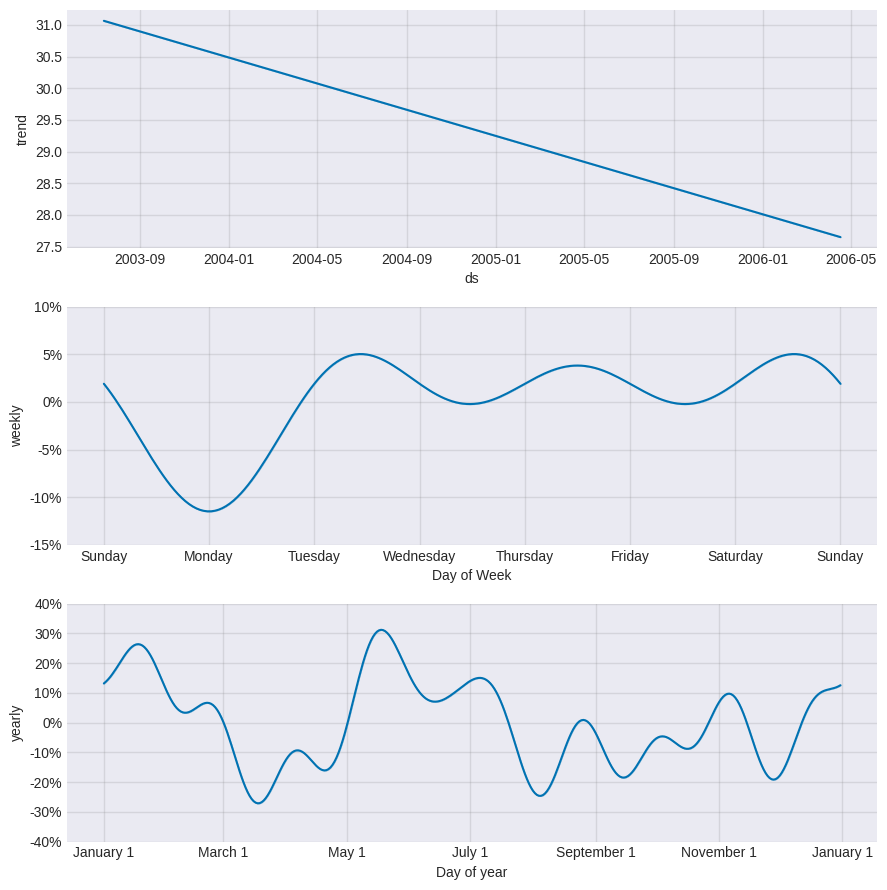

In [322]:
# Realizar las predicciones
forecast = modelo_prophet.predict(future)

# Visualizar las predicciones
modelo_prophet.plot(forecast)
plt.show()

# --------------------------- COMPONENTES DEL MODELO ---------------------------
modelo_prophet.plot_components(forecast)
plt.show()

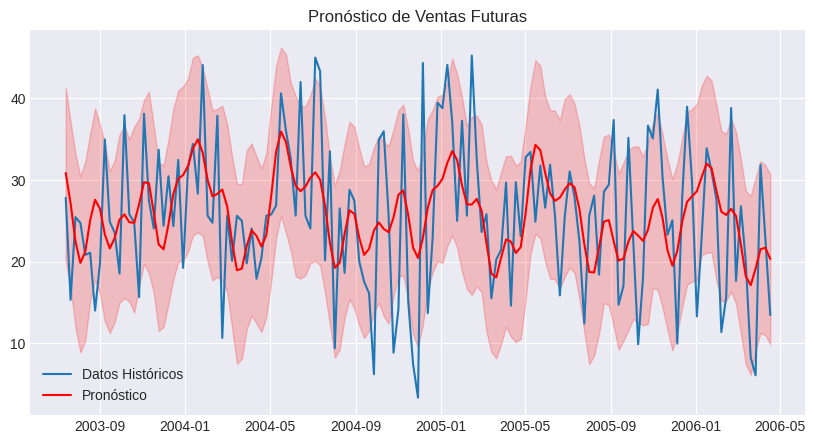

In [323]:
# Pronóstico para los siguientes 30 días
forecast_futuro = modelo_prophet.predict(future)
forecast_ci = forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Visualización de las predicciones a futuro
plt.figure(figsize=(10,5))
plt.plot(df['ds'], df['y'], label="Datos Históricos")
plt.plot(forecast_futuro['ds'], forecast_futuro['yhat'], label="Pronóstico", color='red')
plt.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Pronóstico de Ventas Futuras")
plt.show()